#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [1]:
!pip install pandas
!pip install tensorflow
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [4]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"



Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

## Importación de librerías necesarias para el notebook

In [2]:
import pandas
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob
import re

Ejemplo de salida de una imágen luego de aplicada la transformación Adaptativa

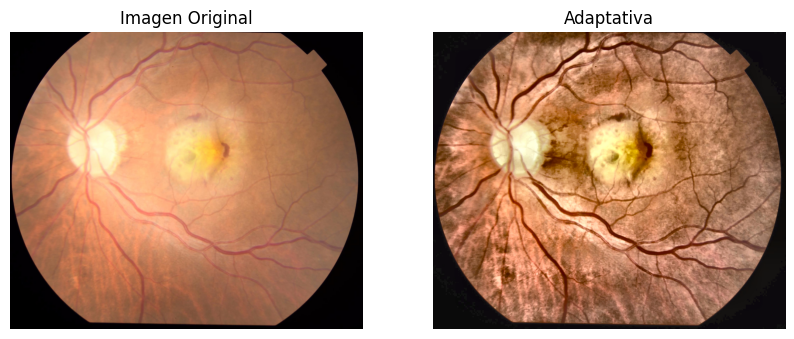

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

image_path = '/content/DS_TFE_Final/test/Macular_Scar/Macular Scar125-flip.jpg'
image = cv2.imread(image_path)

if image.dtype == np.float32 or image.dtype == np.float64:
    image = (image * 255).astype(np.uint8)

lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
l_channel, a_channel, b_channel = cv2.split(lab_image)
l_channel_eq = exposure.equalize_adapthist(l_channel, clip_limit=0.03)
l_channel_eq_uint8 = (255 * l_channel_eq).astype(np.uint8)
lab_image_eq = cv2.merge((l_channel_eq_uint8, a_channel, b_channel))
image_eq = cv2.cvtColor(lab_image_eq, cv2.COLOR_LAB2RGB)

# Mostrar la imagen original y la imagen con transf. adaptativa
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Adaptativa')
plt.imshow(cv2.cvtColor(image_eq, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [6]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Chequeo de cantidad de imágenes cargadas en cada directorio.

In [ ]:
cataract_images = glob.glob(train_dir+"/Cataract/*.jpg")
diabetic_retinopathy_images = glob.glob(train_dir+"/Diabetic_Retinopathy/*.jpg")
glaucoma_images = glob.glob(train_dir+"/Glaucoma/*.jpg")
healthy_images = glob.glob(train_dir+"/Healthy/*.jpg")
macular_scar_images = glob.glob(train_dir+"/Macular_Scar/*.jpg")
myopia_images = glob.glob(train_dir+"/Myopia/*.jpg")

print(len(cataract_images))
print(len(diabetic_retinopathy_images))
print(len(glaucoma_images))
print(len(healthy_images))
print(len(macular_scar_images))
print(len(myopia_images))

732
1056
944
717
933
1050


## Generamos un grafico de torta para ver la cantidad de imagenes

De esta forma se puede observar la distribución de clases y el balanceo de clases.

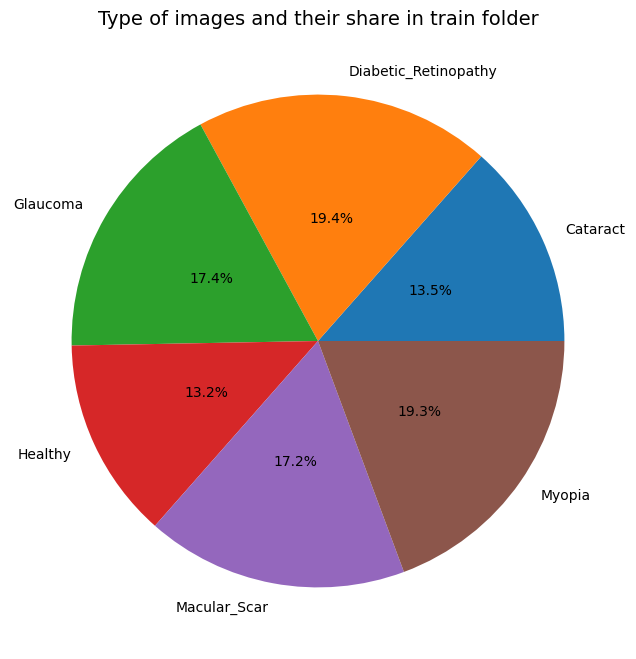

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(x=np.array([len(cataract_images), len(diabetic_retinopathy_images), len(glaucoma_images),
                    len(healthy_images), len(macular_scar_images),len(myopia_images)
                    ]), autopct="%.1f%%", labels=["Cataract", "Diabetic_Retinopathy", "Glaucoma",
                                                  "Healthy", "Macular_Scar", "Myopia"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import exposure

def preprocessing_image(image):
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)

    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_channel_eq = exposure.equalize_adapthist(l_channel, clip_limit=0.03)
    l_channel_eq_uint8 = (255 * l_channel_eq).astype(np.uint8)
    lab_image_eq = cv2.merge((l_channel_eq_uint8, a_channel, b_channel))
    image_eq = cv2.cvtColor(lab_image_eq, cv2.COLOR_LAB2RGB)
    image_eq_resized = cv2.resize(image_eq, (224,224))
    image_eq_preprocessed = preprocess_input(image_eq_resized.astype(np.float32))

    return image_eq_preprocessed

## Visualizamos algunas de las imagenes del dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
val_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
test_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

input_shape = (224, 224, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [ ]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(15,15))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(15,15))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [ ]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [ ]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
model1 = Sequential()
model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D())
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='softmax'))
model1.summary()

model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

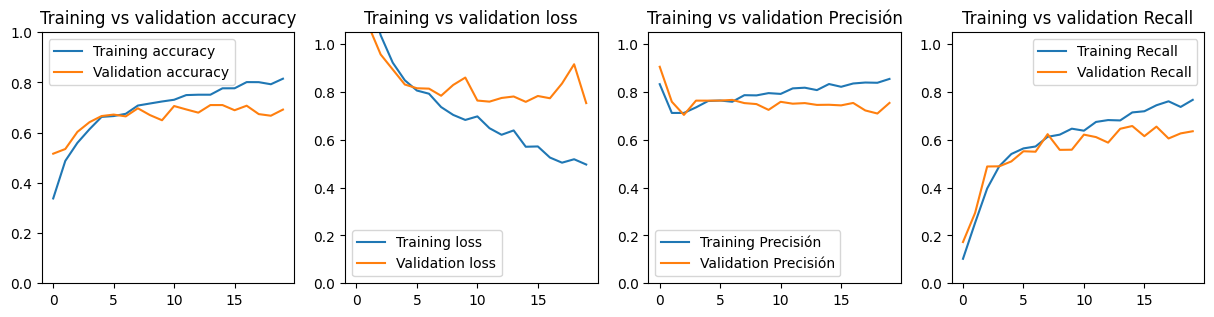

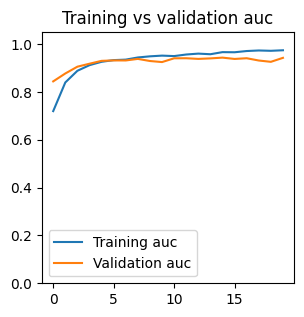

In [ ]:
graph(history1)

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)

39/39 [==============================] - 19s 494ms/step


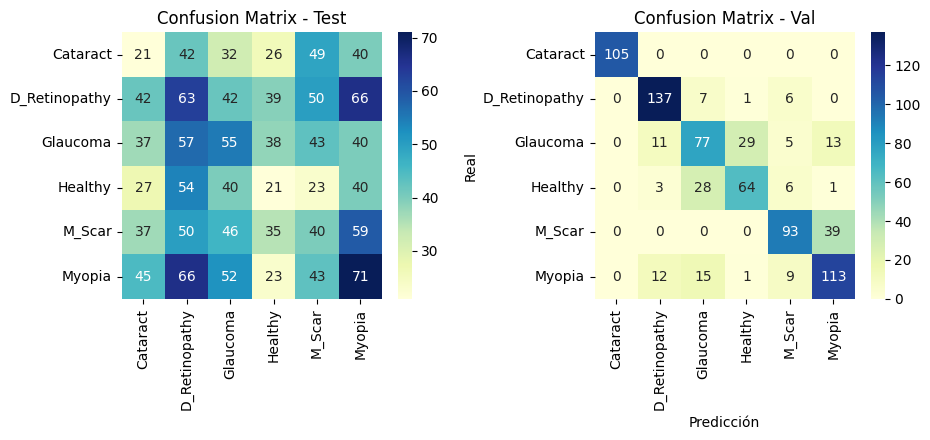

In [ ]:
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model1, y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model1, y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       210
           1       0.19      0.21      0.20       302
           2       0.21      0.20      0.20       270
           3       0.12      0.10      0.11       205
           4       0.16      0.15      0.16       267
           5       0.22      0.24      0.23       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.84      0.91      0.87       151
           2       0.61      0.57      0.59       135
           3       0.67      0.63      0.65       102
           4       0.78      0.70      0.74       132
           5       0.68      0.75      0.72       150

    accuracy                           0.76       775
   macro avg       0.76

## Modelo 4

In [ ]:
model4 = Sequential()
model4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(MaxPooling2D())
model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model4.add(MaxPooling2D())
model4.add(Flatten())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 26, 26, 64)       

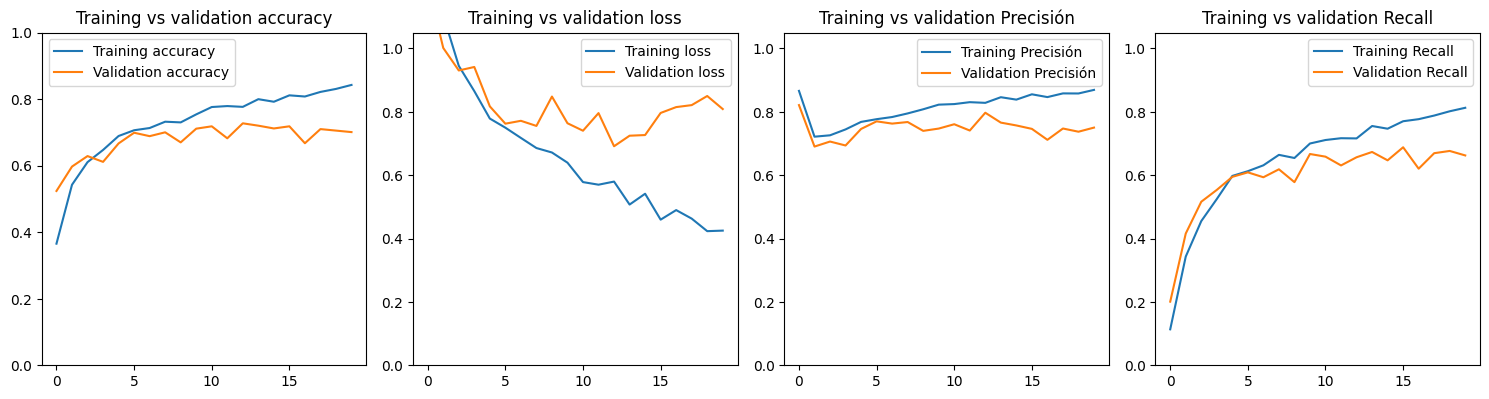

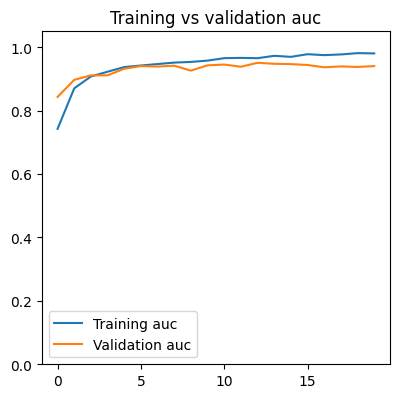

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 18s 480ms/step


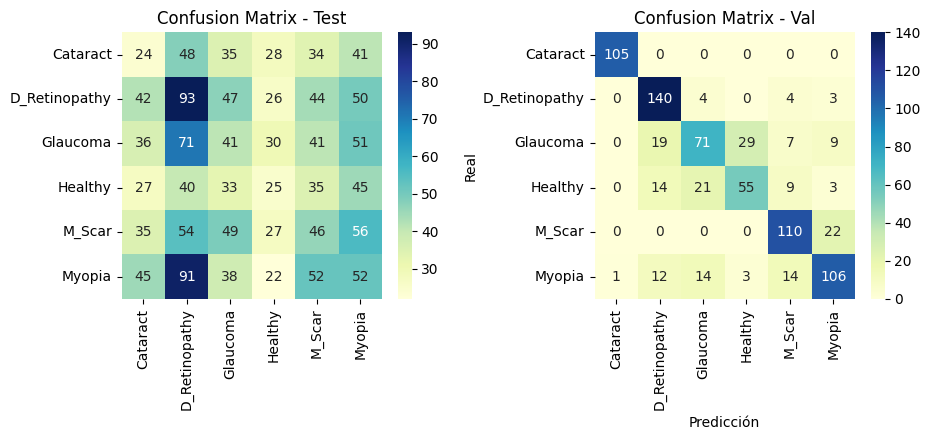

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model4, y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model4, y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.11      0.11       210
           1       0.23      0.31      0.27       302
           2       0.17      0.15      0.16       270
           3       0.16      0.12      0.14       205
           4       0.18      0.17      0.18       267
           5       0.18      0.17      0.17       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.76      0.93      0.83       151
           2       0.65      0.53      0.58       135
           3       0.63      0.54      0.58       102
           4       0.76      0.83      0.80       132
           5       0.74      0.71      0.72       150

    accuracy                           0.76       775
   macro avg       0.76

## Modelo 5

In [ ]:
model5 = Sequential()
model5.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model5.add(MaxPooling2D())
model5.add(Flatten())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))
model5.summary()

model5.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 26, 26, 64)       

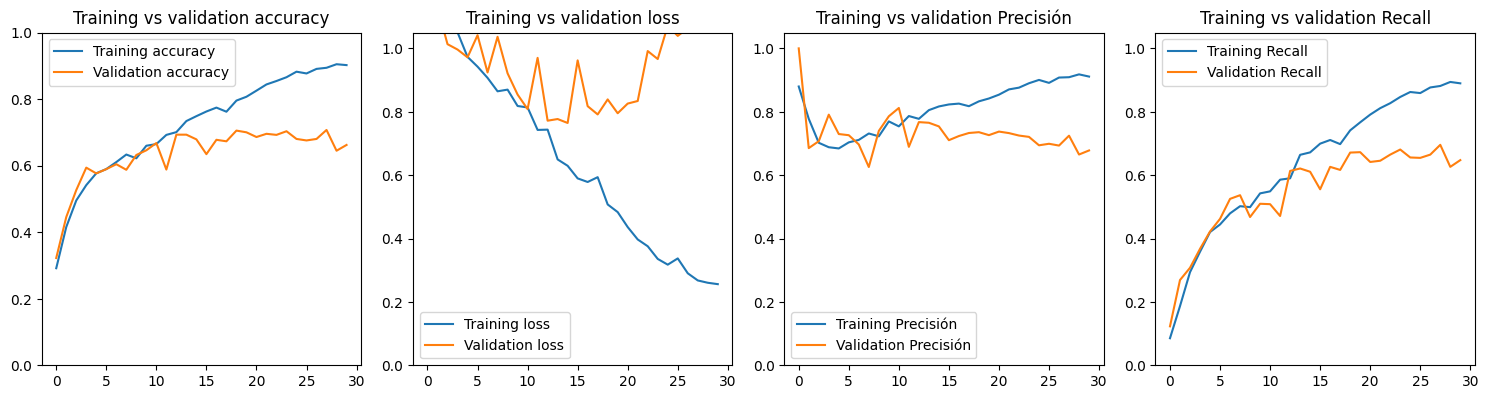

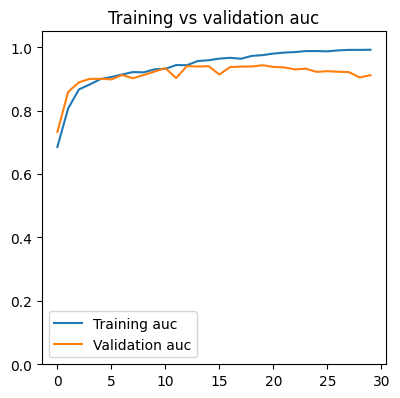

In [ ]:
graph(history5)

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)

39/39 [==============================] - 18s 461ms/step


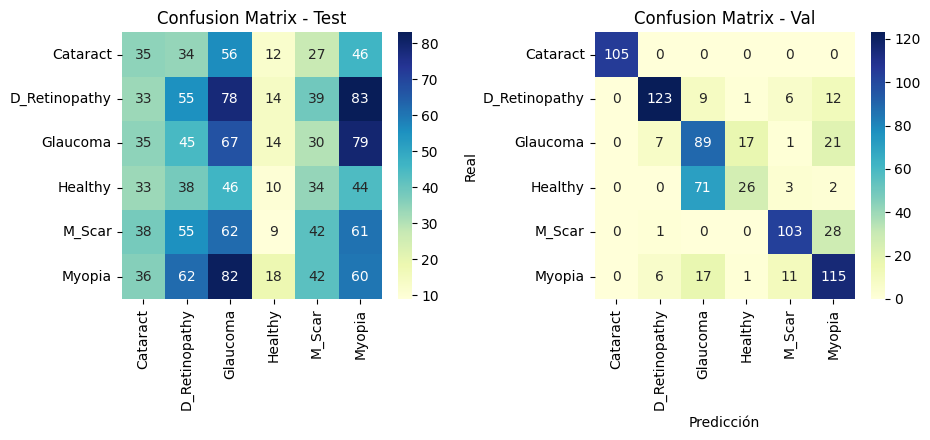

In [ ]:
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model5, y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model5, y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       210
           1       0.19      0.18      0.19       302
           2       0.17      0.25      0.20       270
           3       0.13      0.05      0.07       205
           4       0.20      0.16      0.17       267
           5       0.16      0.20      0.18       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.90      0.81      0.85       151
           2       0.48      0.66      0.55       135
           3       0.58      0.25      0.35       102
           4       0.83      0.78      0.80       132
           5       0.65      0.77      0.70       150

    accuracy                           0.72       775
   macro avg       0.74

## Modelo 15

In [ ]:
model15 = Sequential()
model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model15.add(MaxPooling2D())
model15.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model15.add(MaxPooling2D())
model15.add(Flatten())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))
model15.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 26, 26, 64)       

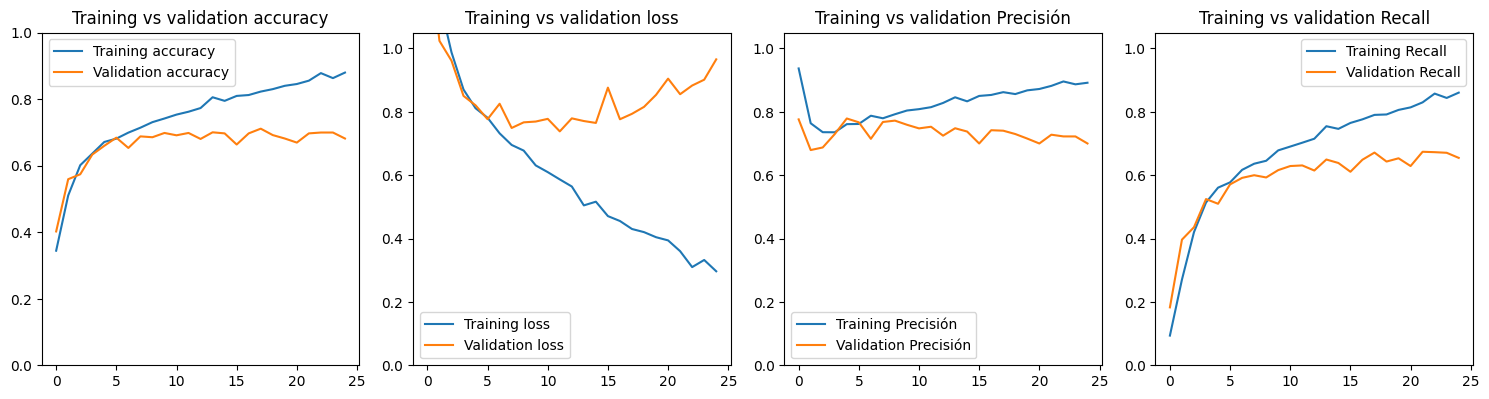

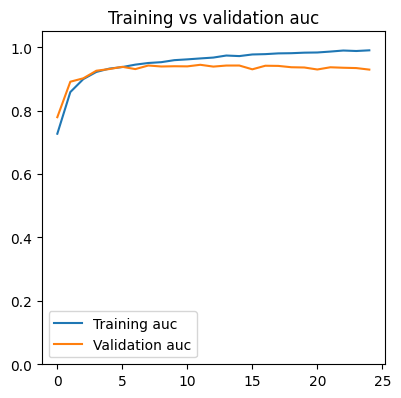

In [ ]:
graph(history15)

39/39 [==============================] - 18s 475ms/step


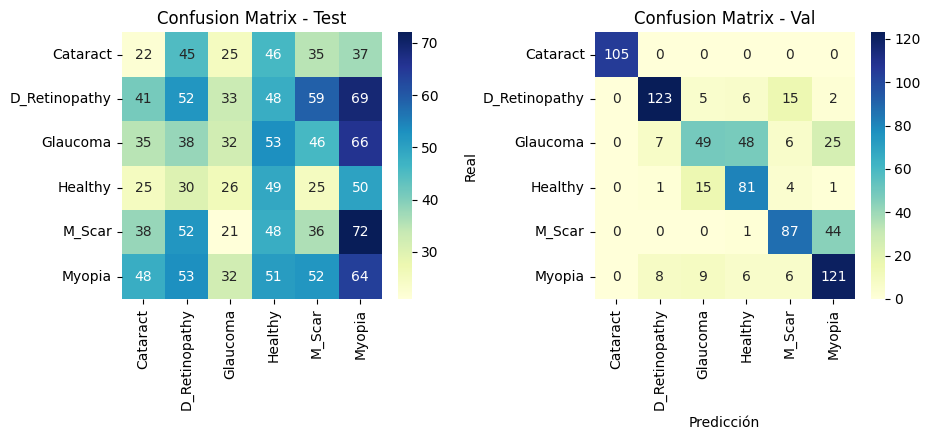

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model15, y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model15, y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.10      0.11       210
           1       0.19      0.17      0.18       302
           2       0.19      0.12      0.15       270
           3       0.17      0.24      0.20       205
           4       0.14      0.13      0.14       267
           5       0.18      0.21      0.19       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.88      0.81      0.85       151
           2       0.63      0.36      0.46       135
           3       0.57      0.79      0.66       102
           4       0.74      0.66      0.70       132
           5       0.63      0.81      0.71       150

    accuracy                           0.73       775
   macro avg       0.74

## Modelo 16

In [ ]:
model16 = Sequential()
model16.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model16.add(MaxPooling2D())
model16.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model16.add(MaxPooling2D())
model16.add(Flatten())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 26, 26, 64)       

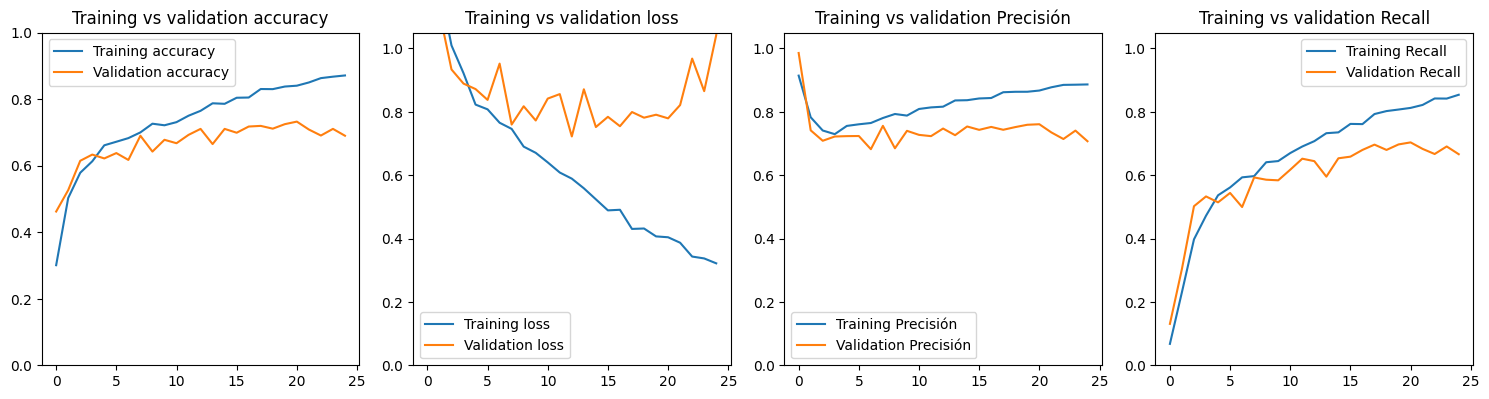

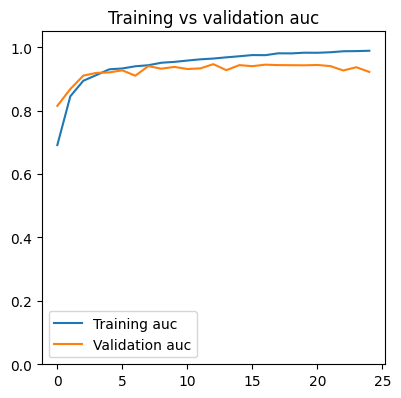

In [ ]:
graph(history16)

39/39 [==============================] - 18s 466ms/step


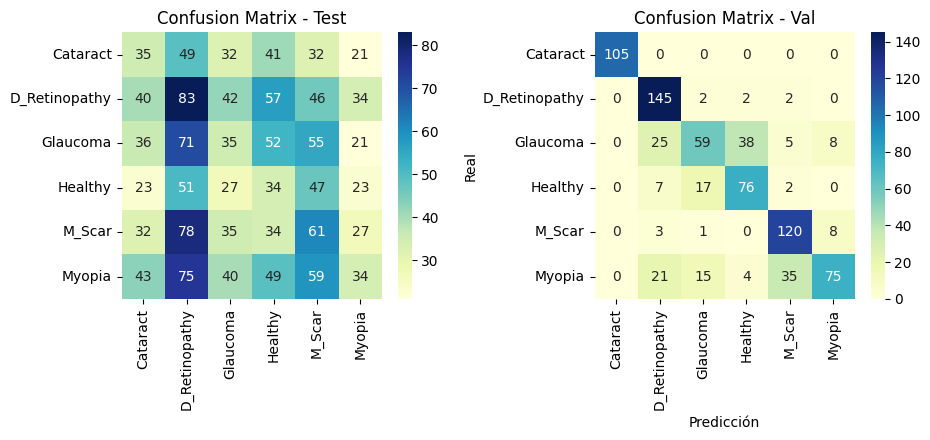

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model16, y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model16, y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       210
           1       0.20      0.27      0.23       302
           2       0.17      0.13      0.15       270
           3       0.13      0.17      0.14       205
           4       0.20      0.23      0.22       267
           5       0.21      0.11      0.15       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.72      0.96      0.82       151
           2       0.63      0.44      0.52       135
           3       0.63      0.75      0.68       102
           4       0.73      0.91      0.81       132
           5       0.82      0.50      0.62       150

    accuracy                           0.75       775
   macro avg       0.76

## Modelo 6

In [ ]:
model6 = Sequential()
model6.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model6.add(MaxPooling2D())
model6.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model6.add(MaxPooling2D())
model6.add(Flatten())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 26, 26, 64)       

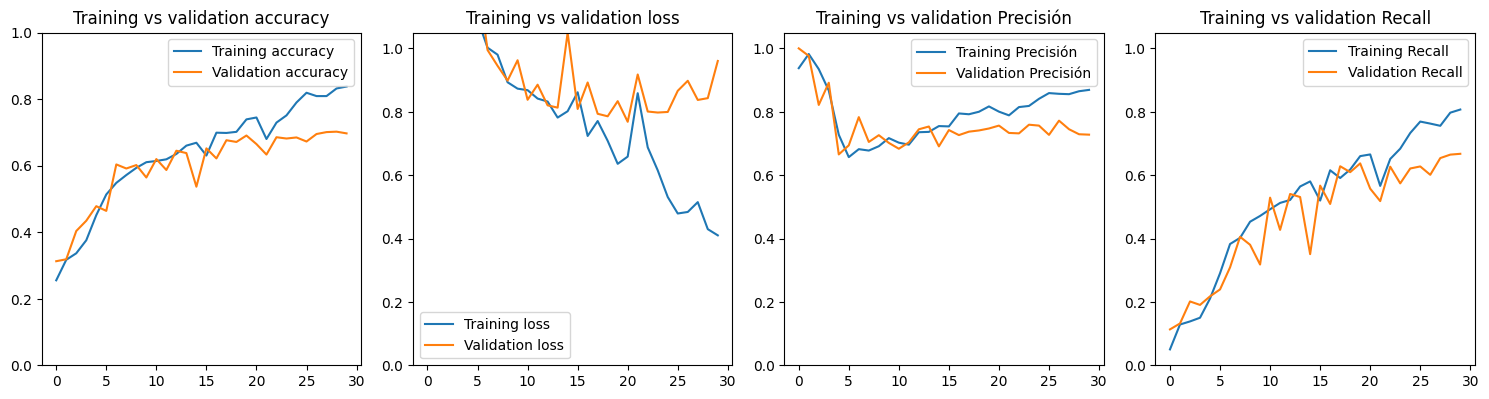

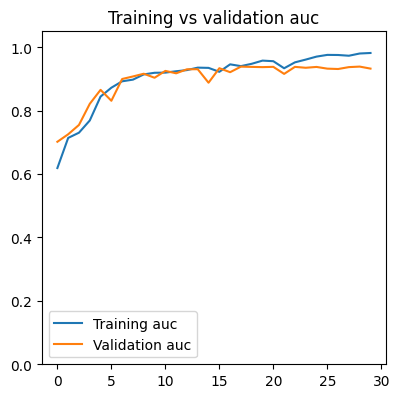

In [ ]:
graph(history6)

In [ ]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 17s 444ms/step


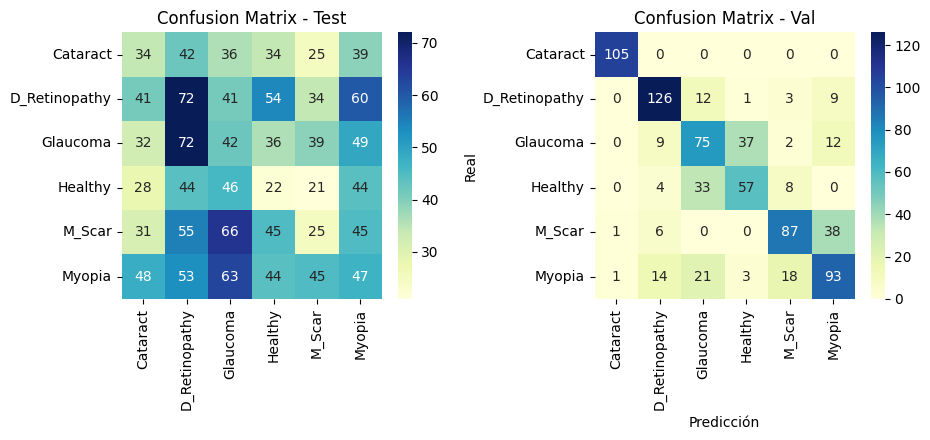

In [ ]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model6, y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model6, y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       210
           1       0.21      0.24      0.23       302
           2       0.14      0.16      0.15       270
           3       0.09      0.11      0.10       205
           4       0.13      0.09      0.11       267
           5       0.17      0.16      0.16       300

    accuracy                           0.16      1554
   macro avg       0.15      0.15      0.15      1554
weighted avg       0.15      0.16      0.15      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.79      0.83      0.81       151
           2       0.53      0.56      0.54       135
           3       0.58      0.56      0.57       102
           4       0.74      0.66      0.70       132
           5       0.61      0.62      0.62       150

    accuracy                           0.70       775
   macro avg       0.71

## Modelo 20


In [ ]:
model20 = Sequential()
model20.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model20.add(MaxPooling2D())
model20.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model20.add(MaxPooling2D())
model20.add(Flatten())
model20.add(Dense(512, activation = 'relu'))
model20.add(Dense(6, activation='softmax'))

# Imprimir un resumen del modelo
model20.summary()

# Compilar el modelo
model20.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model20.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

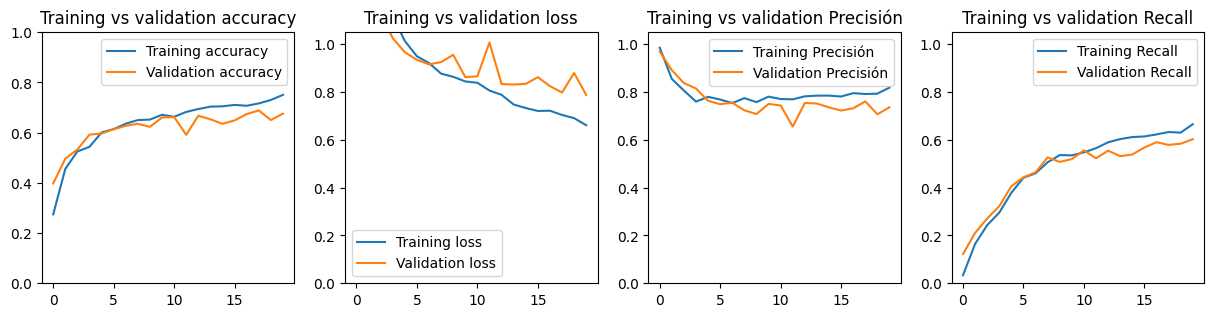

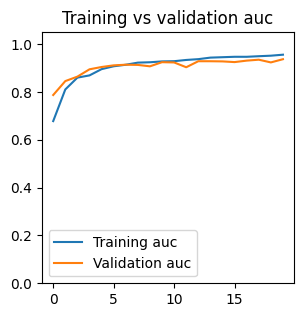

In [ ]:
graph(history_dense)

39/39 [==============================] - 19s 483ms/step


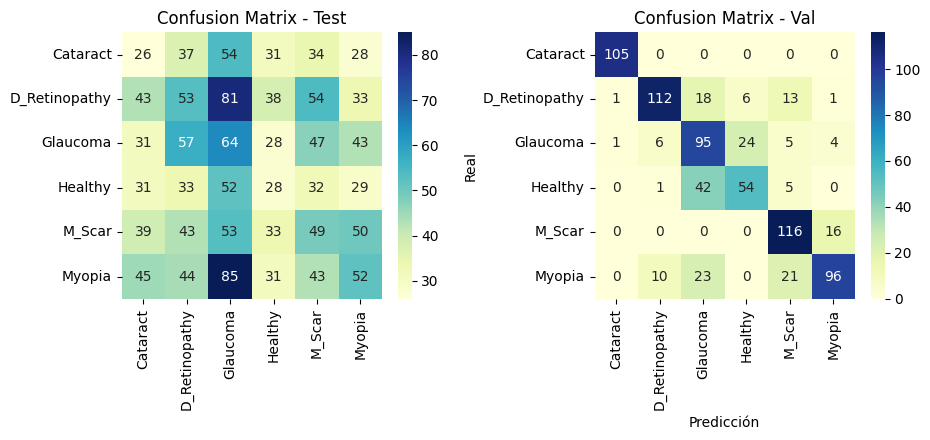

In [ ]:
y_pred_test = model20.predict(test_generator)
y_pred_val = model20.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model20, y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model20, y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.20      0.18      0.19       302
           2       0.16      0.24      0.19       270
           3       0.15      0.14      0.14       205
           4       0.19      0.18      0.19       267
           5       0.22      0.17      0.19       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.87      0.74      0.80       151
           2       0.53      0.70      0.61       135
           3       0.64      0.53      0.58       102
           4       0.72      0.88      0.79       132
           5       0.82      0.64      0.72       150

    accuracy                           0.75       775
   macro avg       0.76

## Modelo 19

In [ ]:
model19 = Sequential()
model19.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model19.add(MaxPooling2D())
model19.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model19.add(MaxPooling2D())
model19.add(Flatten())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 116s 733ms/step - loss: 1.6659 - accuracy: 0.2457 - precision: 0.9375 - recall: 0.0301 - auc: 0.6272 - val_loss: 1.4448 - val_accuracy: 0.3230 - val_precision: 0.7312 - val_recall: 0.1313 - val_auc: 0.7408
Epoch 2/25
150/150 [==============================] - 109s 730ms/step - loss: 1.3567 - accuracy: 0.4057 - precision: 0.8911 - recall: 0.1504 - auc: 0.7764 - val_loss: 1.2061 - val_accuracy: 0.5142 - val_precision: 0.8424 - val_recall: 0.2098 - val_auc: 0.8458
Epoch 3/25
150/150 [==============================] - 110s 734ms/step - loss: 1.1713 - accuracy: 0.5043 - precision: 0.7871 - recall: 0.2607 - auc: 0.8517 - val_loss: 1.1612 - val_accuracy: 0.5341 - val_precision: 0.6856 - val_recall: 0.4112 - val_auc: 0.8606
Epoch 4/25
150/150 [==============================] - 116s 777ms/step - loss: 1.0388 - accuracy: 0.5638 - precision: 0.7330 - recall: 0.3606 - auc: 0.8878 - val_loss: 0.9896 - val_accuracy: 0.5689 - val_precision: 0.7076

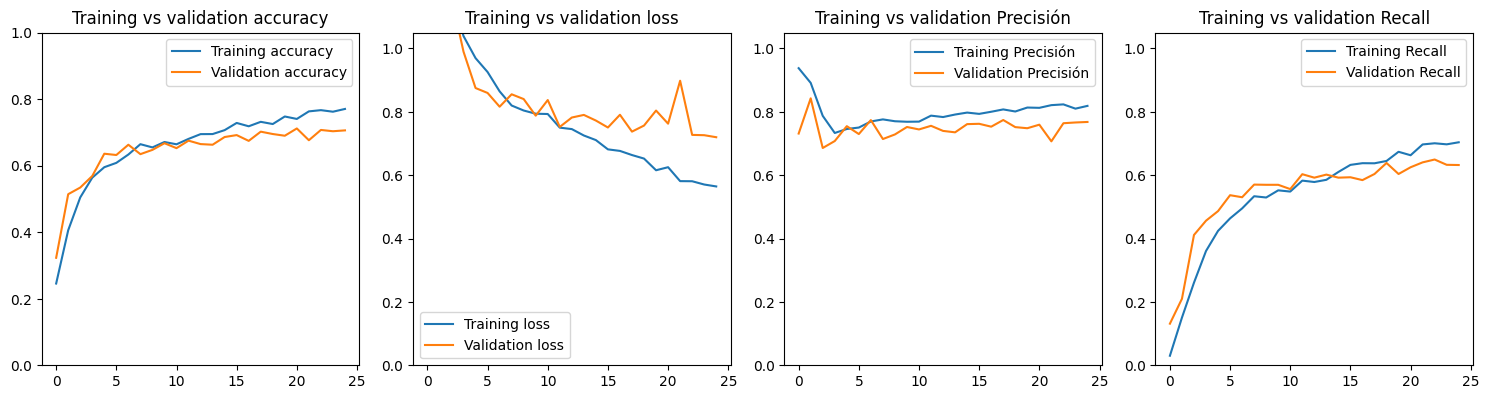

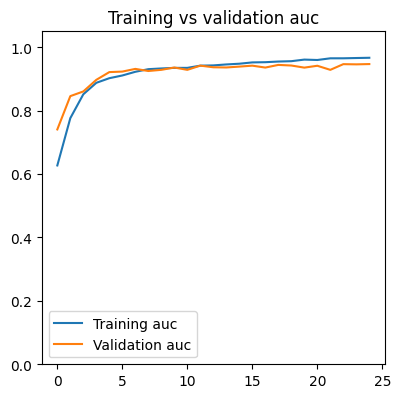

In [ ]:
graph(history19)

39/39 [==============================] - 18s 459ms/step


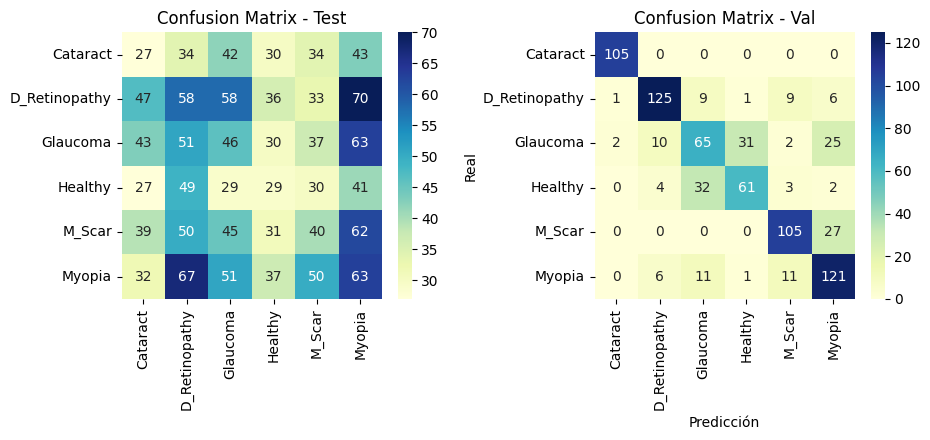

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model19, y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model19, y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.19      0.19      0.19       302
           2       0.17      0.17      0.17       270
           3       0.15      0.14      0.15       205
           4       0.18      0.15      0.16       267
           5       0.18      0.21      0.20       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.86      0.83      0.84       151
           2       0.56      0.48      0.52       135
           3       0.65      0.60      0.62       102
           4       0.81      0.80      0.80       132
           5       0.67      0.81      0.73       150

    accuracy                           0.75       775
   macro avg       0.75

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 127s 468ms/step - loss: 0.4416 - accuracy: 0.8277 - precision: 0.8793 - recall: 0.7682 - auc: 0.9809
Evaluar con Validación:
78/78 [==============================] - 35s 452ms/step - loss: 0.7534 - accuracy: 0.6918 - precision: 0.7542 - recall: 0.6358 - auc: 0.9427
Evaluar con Prueba:
39/39 [==============================] - 19s 483ms/step - loss: 0.5976 - accuracy: 0.7600 - precision: 0.7948 - recall: 0.7045 - auc: 0.9615


In [ ]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 125s 460ms/step - loss: 0.4173 - accuracy: 0.8452 - precision: 0.8814 - recall: 0.8017 - auc: 0.9818
Evaluar con Validación:
78/78 [==============================] - 36s 462ms/step - loss: 0.8085 - accuracy: 0.7008 - precision: 0.7500 - recall: 0.6622 - auc: 0.9406
Evaluar con Prueba:
39/39 [==============================] - 17s 447ms/step - loss: 0.6533 - accuracy: 0.7574 - precision: 0.7926 - recall: 0.7200 - auc: 0.9607


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 135s 497ms/step - loss: 0.2724 - accuracy: 0.8940 - precision: 0.9029 - recall: 0.8849 - auc: 0.9914
Evaluar con Validación:
78/78 [==============================] - 35s 442ms/step - loss: 1.2489 - accuracy: 0.6622 - precision: 0.6779 - recall: 0.6474 - auc: 0.9119
Evaluar con Prueba:
39/39 [==============================] - 19s 504ms/step - loss: 0.9561 - accuracy: 0.7239 - precision: 0.7329 - recall: 0.7045 - auc: 0.9339


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 122s 450ms/step - loss: 0.2736 - accuracy: 0.8945 - precision: 0.9102 - recall: 0.8713 - auc: 0.9921
Evaluar con Validación:
78/78 [==============================] - 36s 458ms/step - loss: 0.9654 - accuracy: 0.6815 - precision: 0.6999 - recall: 0.6544 - auc: 0.9295
Evaluar con Prueba:
39/39 [==============================] - 18s 458ms/step - loss: 0.7966 - accuracy: 0.7303 - precision: 0.7439 - recall: 0.7084 - auc: 0.9473


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 126s 463ms/step - loss: 0.3448 - accuracy: 0.8566 - precision: 0.8766 - recall: 0.8398 - auc: 0.9870
Evaluar con Validación:
78/78 [==============================] - 35s 450ms/step - loss: 1.0418 - accuracy: 0.6898 - precision: 0.7070 - recall: 0.6660 - auc: 0.9222
Evaluar con Prueba:
39/39 [==============================] - 19s 492ms/step - loss: 0.7722 - accuracy: 0.7484 - precision: 0.7587 - recall: 0.7303 - auc: 0.9526


In [ ]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 128s 468ms/step - loss: 0.3304 - accuracy: 0.8730 - precision: 0.8930 - recall: 0.8468 - auc: 0.9883
Evaluar con Validación:
78/78 [==============================] - 36s 462ms/step - loss: 0.9602 - accuracy: 0.6969 - precision: 0.7277 - recall: 0.6673 - auc: 0.9327
Evaluar con Prueba:
39/39 [==============================] - 17s 440ms/step - loss: 0.8644 - accuracy: 0.7006 - precision: 0.7266 - recall: 0.6723 - auc: 0.9423


In [ ]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 125s 460ms/step - loss: 0.4683 - accuracy: 0.8209 - precision: 0.8803 - recall: 0.7419 - auc: 0.9789
Evaluar con Validación:
78/78 [==============================] - 36s 462ms/step - loss: 0.7196 - accuracy: 0.7059 - precision: 0.7678 - recall: 0.6319 - auc: 0.9470
Evaluar con Prueba:
39/39 [==============================] - 17s 450ms/step - loss: 0.5817 - accuracy: 0.7510 - precision: 0.8024 - recall: 0.6813 - auc: 0.9641


In [ ]:
evaluar_modelo(model20)

Evaluar con Entrenamiento:
272/272 [==============================] - 158s 582ms/step - loss: 0.6398 - accuracy: 0.7463 - precision: 0.8103 - recall: 0.6747 - auc: 0.9584
Evaluar con Validación:
78/78 [==============================] - 38s 479ms/step - loss: 0.7877 - accuracy: 0.6757 - precision: 0.7358 - recall: 0.6023 - auc: 0.9370
Evaluar con Prueba:
39/39 [==============================] - 18s 467ms/step - loss: 0.6345 - accuracy: 0.7458 - precision: 0.7880 - recall: 0.6761 - auc: 0.9584
